In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm
import os
import shutil
from sklearn.model_selection import train_test_split
import seaborn as sns
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import time

In [3]:
from os import listdir
from os.path import isfile, join

def count_class(dir):
    return sum(1 for entry in os.listdir(dir) if os.path.isfile(os.path.join(dir,entry)))

In [4]:
test_dir = '/Users/harrisongetter/Desktop/Spring 2023/EE 541/Project/Project_Code/Data/archive_new/Testing/testing'
train_dir = '/Users/harrisongetter/Desktop/Spring 2023/EE 541/Project/Project_Code/Data/archive_new/Training'
val_dir = '/Users/harrisongetter/Desktop/Spring 2023/EE 541/Project/Project_Code/Data/archive_new/Validation'

# Print the number of images in each category for the training set
print('Training set:')
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    print(class_name + ':', len(os.listdir(class_dir)))

# Print the number of images in each category for the validation set
print('Validation set:')
for class_name in os.listdir(val_dir):
    class_dir = os.path.join(val_dir, class_name)
    print(class_name + ':', len(os.listdir(class_dir)))

batch_size = 32
epochs = 10

# # Create an instance of the VGG16 model
# vgg = models.vgg16(pretrained=True)

# # Freeze the layers in the VGG16 model
# for param in vgg.parameters():
#     param.requires_grad = False

model = torchvision.models.resnet50()

# Modify the last linear layer to include dropout
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.6),  # Add dropout layer with dropout rate of 0.5
    torch.nn.Linear(in_features=2048, out_features=1),
    torch.nn.Sigmoid()
)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Create transforms for the training and validation data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



# Create datasets for the training and validation data
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

# Create WeightedSampler for training
train_num_class_1 = count_class(train_dir + "/tumor")
train_num_class_0 = count_class(train_dir + "/notumor")
train_total = train_num_class_1+train_num_class_0
train_weights = [train_total/train_num_class_0, train_total/train_num_class_1]
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, len(train_dataset))

# Create data loaders for the training and validation data
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)


Training set:
tumor: 4018
notumor: 1600
Validation set:
tumor: 1005
notumor: 400


In [5]:

import time

def print_time(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# Lists to store the training and testing accuracy and loss values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

count = 0
# Train the model
for epoch in range(epochs):
    start = time.time()
    count +=1
    print("Running epoch: ", count)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = outputs > 0.5
        total += labels.size(0)
        correct += (predicted == labels.float().unsqueeze(1)).sum().item()

    print("Done Training", "time: ", print_time(start, time.time()))
    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    
    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        start = time.time()
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)
            predicted = outputs > 0.5
            total += labels.size(0)
            correct += (predicted == labels.float().unsqueeze(1)).sum().item()
    print("Done val", "time: ", print_time(start, time.time()))
    val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    
    # Append the training and validation accuracy and loss values
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} -- Training Loss: {train_loss:.4f} -- Training Accuracy: {train_acc:.4f} -- Validation Loss: {val_loss:.4f} -- Validation Accuracy: {val_acc:.4f}')

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        test_loss += loss.item() * inputs.size(0)
        predicted = outputs > 0.5
        total += labels.size(0)
        correct += (predicted == labels.float().unsqueeze(1)).sum().item()

        # Append true labels and predicted labels to the respective lists
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

test_loss = test_loss / len(test_dataset)
test_acc = correct / total
print(f'Test Loss: {test_loss:.4f} -- Test Accuracy: {test_acc:.4f}')

# Plot the training and validation accuracy curves
plt.figure()
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
confusion_matrix_test = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Running epoch:  1
00:28:02.47
Done Training time:  None
00:03:54.51
Done val time:  None
Epoch 1/10 -- Training Loss: 0.0047 -- Training Accuracy: 0.9956 -- Validation Loss: 71.5302 -- Validation Accuracy: 0.2847
Running epoch:  2
00:31:47.77
Done Training time:  None
00:04:25.92
Done val time:  None
Epoch 2/10 -- Training Loss: 0.0002 -- Training Accuracy: 1.0000 -- Validation Loss: 71.5302 -- Validation Accuracy: 0.2847
Running epoch:  3
00:27:44.03
Done Training time:  None
00:04:01.81
Done val time:  None
Epoch 3/10 -- Training Loss: 0.0003 -- Training Accuracy: 1.0000 -- Validation Loss: 2.0855 -- Validation Accuracy: 0.2847
Running epoch:  4
00:27:36.21
Done Training time:  None
00:03:38.75
Done val time:  None
Epoch 4/10 -- Training Loss: 0.0005 -- Training Accuracy: 1.0000 -- Validation Loss: 1.5464 -- Validation Accuracy: 0.2847
Running epoch:  5
00:31:35.41
Done Training time:  None
00:06:31.62
Done val time:  None
Epoch 5/10 -- Training Loss: 0.0004 -- Training Accuracy: 1.0

In [ ]:
torch.save(model.state_dict(), "model_state.pth")

# With Cross Entropy Loss

Training set:
tumor: 4018
notumor: 1600
Validation set:
tumor: 1005
notumor: 400
Running epoch:  1
00:35:47.96
Done Training time:  None
00:02:49.76
Done val time:  None
Epoch 1/10 -- Training Loss: 0.0000 -- Training Accuracy: 0.4753 -- Validation Loss: 0.0000 -- Validation Accuracy: 0.7153
Running epoch:  2
00:18:48.17
Done Training time:  None
00:02:47.92
Done val time:  None
Epoch 2/10 -- Training Loss: 0.0000 -- Training Accuracy: 0.3147 -- Validation Loss: 0.0000 -- Validation Accuracy: 0.2847
Running epoch:  3
00:18:13.30
Done Training time:  None
00:02:52.30
Done val time:  None
Epoch 3/10 -- Training Loss: 0.0000 -- Training Accuracy: 0.2848 -- Validation Loss: 0.0000 -- Validation Accuracy: 0.2847
Running epoch:  4
00:18:24.66
Done Training time:  None
00:02:46.83
Done val time:  None
Epoch 4/10 -- Training Loss: 0.0000 -- Training Accuracy: 0.2848 -- Validation Loss: 0.0000 -- Validation Accuracy: 0.2847
Running epoch:  5
00:17:57.06
Done Training time:  None
00:02:47.76
Don

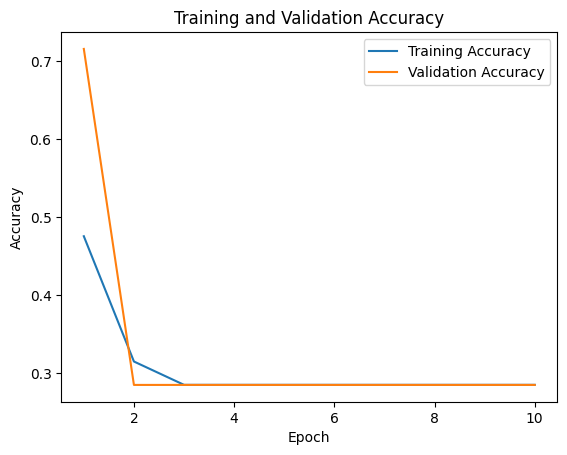

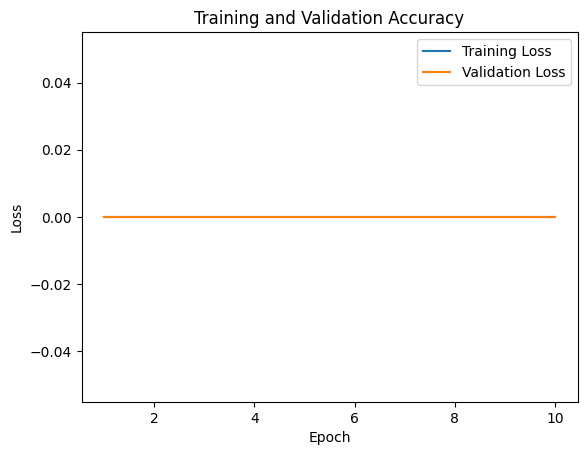

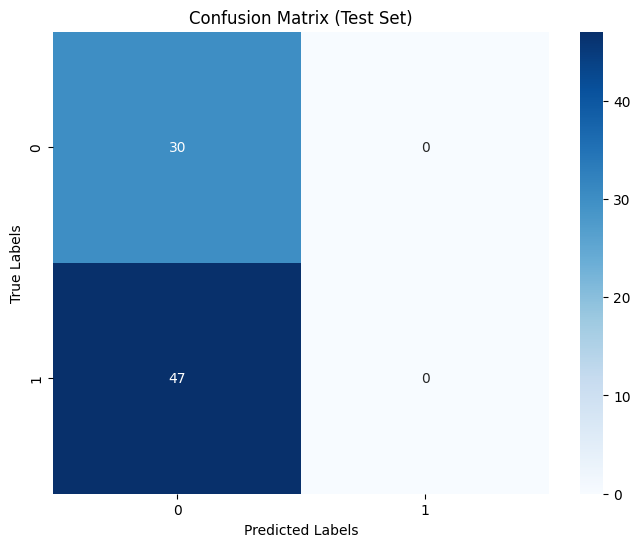

In [4]:
test_dir = '/Users/harrisongetter/Desktop/Spring 2023/EE 541/Project/Project_Code/Data/archive_new/Testing/testing'
train_dir = '/Users/harrisongetter/Desktop/Spring 2023/EE 541/Project/Project_Code/Data/archive_new/Training'
val_dir = '/Users/harrisongetter/Desktop/Spring 2023/EE 541/Project/Project_Code/Data/archive_new/Validation'

# Print the number of images in each category for the training set
print('Training set:')
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    print(class_name + ':', len(os.listdir(class_dir)))

# Print the number of images in each category for the validation set
print('Validation set:')
for class_name in os.listdir(val_dir):
    class_dir = os.path.join(val_dir, class_name)
    print(class_name + ':', len(os.listdir(class_dir)))

batch_size = 32
epochs = 10

# # Create an instance of the VGG16 model
# vgg = models.vgg16(pretrained=True)

# # Freeze the layers in the VGG16 model
# for param in vgg.parameters():
#     param.requires_grad = False

model = torchvision.models.resnet50()

# Modify the last linear layer to include dropout
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.6),  # Add dropout layer with dropout rate of 0.5
    torch.nn.Linear(in_features=2048, out_features=1),
    torch.nn.Sigmoid()
)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Create transforms for the training and validation data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



# Create datasets for the training and validation data
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

# Create WeightedSampler for training
train_num_class_1 = count_class(train_dir + "/tumor")
train_num_class_0 = count_class(train_dir + "/notumor")
train_total = train_num_class_1+train_num_class_0
train_weights = [train_total/train_num_class_0, train_total/train_num_class_1]
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, len(train_dataset))

# Create data loaders for the training and validation data
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

def print_time(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# Lists to store the training and testing accuracy and loss values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

count = 0
# Train the model
for epoch in range(epochs):
    start = time.time()
    count +=1
    print("Running epoch: ", count)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = outputs > 0.5
        total += labels.size(0)
        correct += (predicted == labels.float().unsqueeze(1)).sum().item()

    print("Done Training", "time: ", print_time(start, time.time()))
    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    
    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        start = time.time()
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)
            predicted = outputs > 0.5
            total += labels.size(0)
            correct += (predicted == labels.float().unsqueeze(1)).sum().item()
    print("Done val", "time: ", print_time(start, time.time()))
    val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    
    # Append the training and validation accuracy and loss values
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} -- Training Loss: {train_loss:.4f} -- Training Accuracy: {train_acc:.4f} -- Validation Loss: {val_loss:.4f} -- Validation Accuracy: {val_acc:.4f}')

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        test_loss += loss.item() * inputs.size(0)
        predicted = outputs > 0.5
        total += labels.size(0)
        correct += (predicted == labels.float().unsqueeze(1)).sum().item()

        # Append true labels and predicted labels to the respective lists
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

test_loss = test_loss / len(test_dataset)
test_acc = correct / total
print(f'Test Loss: {test_loss:.4f} -- Test Accuracy: {test_acc:.4f}')

# Plot the training and validation accuracy curves
plt.figure()
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
confusion_matrix_test = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [5]:
torch.save(model.state_dict(), "model_state_cross_entropy.pth")